<a href="https://colab.research.google.com/github/martaarozarena/KSchool-Master-Final-Project/blob/master/exog_varaibles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
plt.rcParams["figure.figsize"] = (15, 8)

In [416]:
# We select the sheets to be used in the Oxford Covid Policy tracker and the countries our project will be working on:
sheets = ["c1_schoolclosing","c2_workplaceclosing","c3_cancelpublicevents","c4_restrictionsongatherings", \
          "c5_closepublictransport","c6_stayathomerequirements","c7_domestictravel","c8_internationaltravel", \
          "h1_publicinfocampaign","h2_testingpolicy","h3_contacttracing"]
countries = 'Denmark|Germany|Spain|Finland|Italy|Sweden|France|Norway|United Kingdom' \
            '|United States|Canada|Mexico' \
            '|Australia|Indonesia|Malaysia|Philippines|Thailand|Hong Kong|Vietnam|China|India|Japan|Singapore|Taiwan' \
            '|Saudi Arabia|United Arab Emirates'
initialdate = "01-01-2020"
#enddate="30-06-2020"

# Downloading and preparing the Oxford Covid Policy Tracker data

In [417]:
# Downloading Oxford Covid Policy Tracker
url1 = "https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx"
var = pd.read_excel(url1,sheet_name=sheets)

In [418]:
for i in var.keys():
  var[i]=var[i].drop("CountryCode",axis=1)
  var[i].index=var[i].CountryName
  var[i]=var[i].drop("CountryName",axis=1)
  var[i]=var[i][:-3]
  var[i]=var[i].T
  var[i]=var[i].loc[:,var[i].columns.str.contains(countries, regex=True)]
  var[i].index=pd.to_datetime(var[i].index,format="%d%b%Y")
#  var[i]=var[i].truncate(initialdate,enddate)

In [419]:
b=1
for i in sheets:
  if b==1: 
    var[i].columns="{}_".format(i[3:])+var[i].columns
    exogenas=var[i]
  else:
    concat=var[i]
    concat.columns="{}_".format(i[3:])+var[i].columns
    exogenas=pd.concat([exogenas,concat],axis=1)
  b=b+1

In [420]:
exogenas.fillna(method="ffill",inplace=True)

In [421]:
exogenas.shape

(231, 286)

# Downloading and preparing the mask wearing data (YouGov)

In [422]:
# We download the mask wearing data
url2 = "https://drive.google.com/file/d/15S6nC4NKDnTj-P6jCcf1LAoH7bgoIzEv/view?usp=sharing"
path2 = 'https://drive.google.com/uc?export=download&id='+url2.split('/')[-2]
var_percent_mask = pd.read_csv(path2, sep=";", parse_dates=['DateTime'], index_col=['DateTime'])

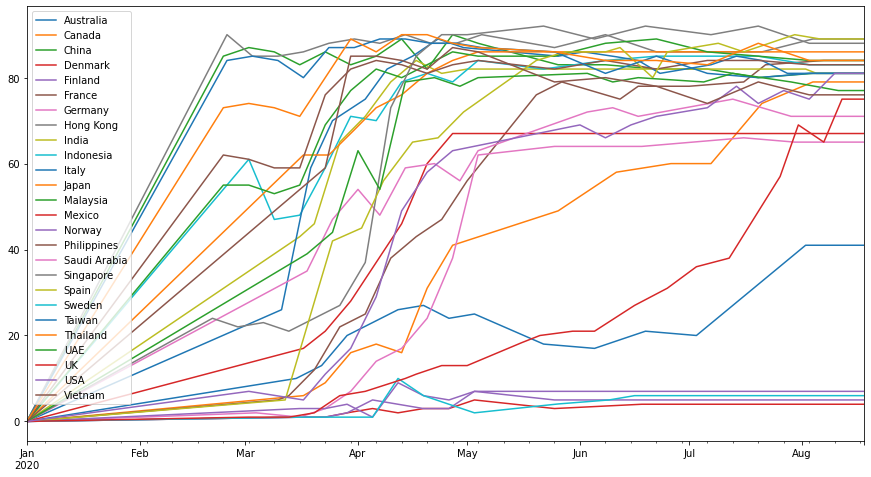

In [423]:
# We extend the dates to match those of the general exogenous dataframe, and we interpolate to fill all the missing values (initializing the series at 0)
var_percent_mask.index = pd.to_datetime(var_percent_mask.index).date
var_percent_mask = var_percent_mask.reindex(exogenas.index)
var_percent_mask.iloc[0] = 0
var_percent_mask = var_percent_mask.interpolate(method='linear')
var_percent_mask.plot()

In [424]:
#rename the variable's columns to be added in the general dataframe
var_percent_mask.columns = "mask_"+var_percent_mask.columns
var_percent_mask.rename(columns={"mask_UAE" : "mask_United Arab Emirates", "mask_UK":"mask_United Kingdom", "mask_USA" : "mask_United States"}, inplace=True)

In [425]:
#add the mask data to the rest of exogenous dataframe
exogenas = pd.concat([exogenas,var_percent_mask],axis=1)

In [426]:
exogenas.shape

(231, 312)

# Downloading and preparing the Flights data (we only have it available for Europe)

In [427]:
#Downloading daily flights from Eurocontrol
#url3 = "https://drive.google.com/file/d/1jLzSGGbQY8OyD1YTNZAJFRmvxy7lA2V_/view?usp=sharing"
#path3 = 'https://drive.google.com/uc?export=download&id='+url3.split('/')[-2]
url3 = 'https://ansperformance.eu/download/xls/Airport_Traffic.xlsx'
flights = pd.read_excel(url3, sheet_name="DATA", date_parser="FLT_DATE", index_col ="FLT_DATE")

In [428]:
# Extractin 
for i in countries.split('|'):
    flights_country = flights[flights["STATE_NAME"]==i]
    flights_country = flights_country.resample("1D").sum()
    flights_country_arr = flights_country['FLT_ARR_1'].truncate(before=initialdate)
    flights_country_arr.rename("FlightsArr_{}".format(i),inplace=True)
    exogenas = pd.concat([exogenas, flights_country_arr], axis=1)

In [429]:
exogenas.loc[:, exogenas.columns.str.contains('Flights')] = exogenas.loc[:, exogenas.columns.str.contains('Flights')].interpolate(method='linear')

In [430]:
exogenas = exogenas.loc[:, :'FlightsArr_United Kingdom']

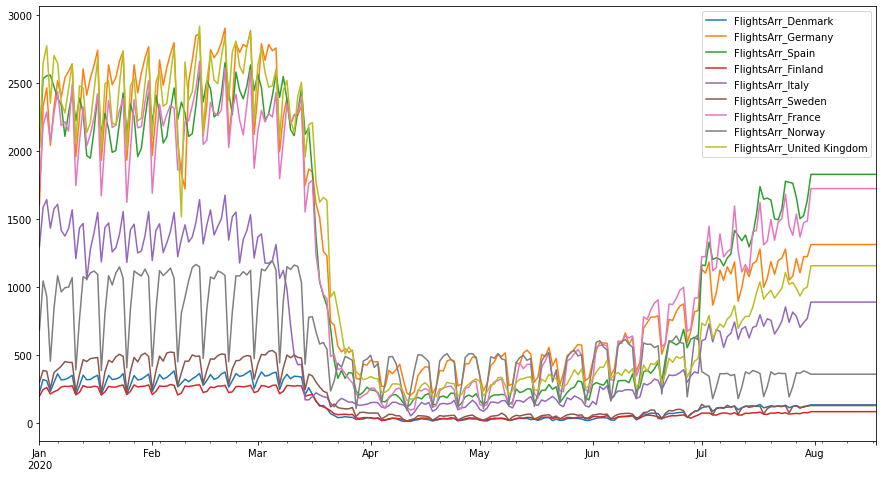

In [431]:
exogenas.loc[:, exogenas.columns.str.contains('Flights')].plot()

In [432]:
exogenas.shape

(231, 321)

In [433]:
#creating the csv file
#exogenas.to_csv('./data/exogenas.csv')

In [434]:
# Downloading and testing data (from Our World in Data)

In [435]:
covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=["date"], index_col="date")

In [436]:
b=0
coviddata=[]
for i in countries.split('|'):
  covid_country=covid[covid["location"]==i]
  covid_country_positive_rate=covid_country['positive_rate']
  covid_country_positive_rate.rename("Positive_rate_{}".format(i),inplace=True)
  if b==0:
    coviddata=covid_country_positive_rate
    b=1
  else:
    coviddata=pd.concat([coviddata,covid_country_positive_rate],axis=1) 


In [437]:
coviddata=coviddata.drop("Positive_rate_China",axis=1) #dropped cause they have no data for positive rate
coviddata=coviddata.drop("Positive_rate_Hong Kong",axis=1)
coviddata.drop(pd.to_datetime("31-12-2019"),axis=0,inplace=True)

In [439]:
columnas=pd.Series(coviddata.columns[coviddata.columns.str.contains('Positive_rate', regex=True)])
columnas=pd.concat([columnas,"dummy_"+columnas])#name for the columns for the imputer in sklearn

In [440]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp_mean_fpd = pd.DataFrame(imp_mean.fit_transform(coviddata), index=coviddata.index,columns=columnas)
exogenas=pd.concat([exogenas,imp_mean_fpd],axis=1)

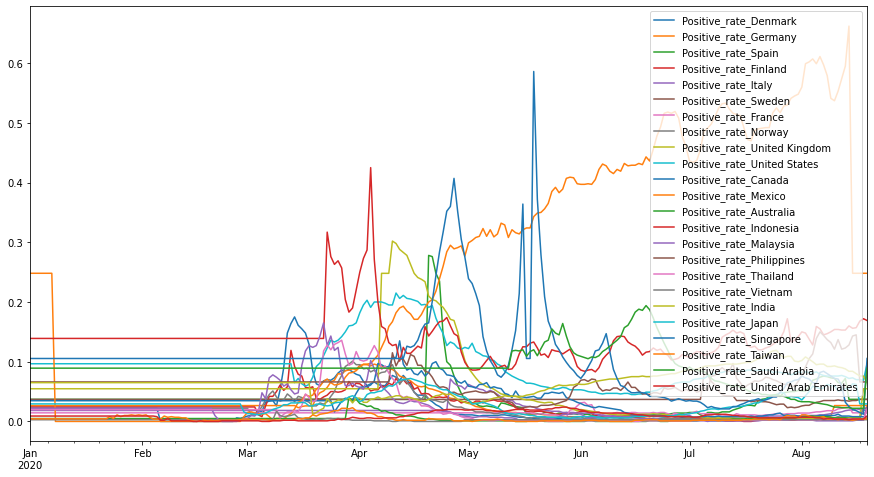

In [443]:
exogenas.loc[:, exogenas.columns.str.startswith('Positive_rate_')].plot()

In [ ]:
#creating the csv file
exogenas.to_csv('./data/exogenas.csv')

In [254]:
exogenas.columns[np.invert(exogenas.columns.str.contains('Positive_rate',regex=True))]

Index(['schoolclosing_United Arab Emirates', 'schoolclosing_Australia',
       'schoolclosing_Canada', 'schoolclosing_China', 'schoolclosing_Germany',
       'schoolclosing_Denmark', 'schoolclosing_Spain', 'schoolclosing_Finland',
       'schoolclosing_France', 'schoolclosing_United Kingdom',
       ...
       'mask_Vietnam', 'FlightsArr_Denmark', 'FlightsArr_Germany',
       'FlightsArr_Spain', 'FlightsArr_Finland', 'FlightsArr_Italy',
       'FlightsArr_Sweden', 'FlightsArr_France', 'FlightsArr_Norway',
       'FlightsArr_United Kingdom'],
      dtype='object', length=321)